In [1]:
import pandas as pd
import numpy as np

from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.pipeline import FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import f1_score, roc_auc_score

from lime.lime_tabular import LimeTabularExplainer

pd.set_option('display.max_columns', None)

In [2]:
# Class to help select categorical vs. continuous data as part of the pipeline (see below)
class DataSelector(BaseEstimator, TransformerMixin):
    '''Select columns of numpy arrays based on attribute_indices.'''

    def __init__(self, attribute_indices):
        self.attribute_indices = attribute_indices

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return np.array(X)[:,self.attribute_indices]

In [3]:
# Load (preprocessed) data
# 
# The raw data was downloaded from https://data.stanford.edu/hcmst and preprocessed.
# We combined data sets collected across several years, we transformed select variables 
# (e.g., partner_education to be at the same level of granularity as education),
# and added variables like the absolute age difference, education difference, etc.
# Finally, we determined whether couples were still together (i.e., our labels).
#
# We provide the preprocessed data as a csv file in the same repo as this notebook.

df = pd.read_csv('couples.csv')

# Order features (numeric first, categorical second) since it's convenient later
feature_order = ['age',
                 'partner_age',
                 'age_diff_abs',
                 'children',
                 'visits_relatives',
                 'education',
                 'marital_status',
                 'partner_education',
                 'gender',
                 'house',
                 'income',
                 'msa',
                 'rent',
                 'political',
                 'religion',
                 'work',
                 'gender_older',
                 'education_difference',
                 'success']

data = df[feature_order]
data = data[data.house != 'boat, rv, van, etc.'] # only one data point with this value, discard

labels = data.pop('success')

In [4]:
# Take a peak at the data
data.head()

,age,partner_age,age_diff_abs,children,visits_relatives,education,marital_status,partner_education,gender,house,income,msa,rent,political,religion,work,gender_older,education_difference
0,52,48,4,0.0,0,bachelor's degree or higher,living with partner,some college,female,a building with 2 or more apartments,"$20,000 to $24,999",metro,rented for cash,democrat,catholic,working - as a paid employee,1,1
1,28,30,2,0.0,0,bachelor's degree or higher,living with partner,bachelor's degree or higher,female,a building with 2 or more apartments,"$40,000 to $49,999",metro,rented for cash,democrat,jewish,working - as a paid employee,0,0
2,31,40,9,0.0,1,some college,never married,high school,male,a building with 2 or more apartments,"$40,000 to $49,999",metro,owned or being bought by you or someone in you...,democrat,"other non-christian, please specify:",working - as a paid employee,1,1
3,53,55,2,0.0,1,bachelor's degree or higher,living with partner,bachelor's degree or higher,male,a one-family house detached from any other house,"$125,000 to $149,999",metro,owned or being bought by you or someone in you...,democrat,"protestant (e.g., methodist, lutheran, presbyt...",working - as a paid employee,1,0
4,58,51,7,0.0,0,bachelor's degree or higher,separated,bachelor's degree or higher,male,a building with 2 or more apartments,"$15,000 to $19,999",metro,rented for cash,democrat,"protestant (e.g., methodist, lutheran, presbyt...",working - as a paid employee,0,0


In [5]:
# Define categorical names and indices
categorical_features = list(data.columns[5:])
categorical_idx = list(range(5, len(data.columns)))
continuous_features = list(data.columns[0:5])
continuous_idx = list(range(0,5))

X = data.values

# Get feature names and their values for categorical data (needed for LIME)
categorical_names = {}
for idx, feature in zip(categorical_idx, categorical_features):
    le = LabelEncoder()
    X[:, idx] = le.fit_transform(X[:, idx])
    categorical_names[idx] = le.classes_

# To suppress a warning later (not strictly necessary)
X = X.astype(float)

# Train test split
train, test, labels_train, labels_test = train_test_split(
    X, labels, train_size=0.70, random_state=42
)

In [6]:
# Preprocessing pipeline
#      
# LIME needs a function that takes raw inputs and returns a prediction (see below).     
# We use sklearn's pipeline to handle preprocessing, it simplifies the interaction with LIME (see below). 
# There are several ways to build this pipeline. For demo purposes, we here show the verbose option (and we
# avoid scaling one-hot encoded features).

continuous_pipeline = Pipeline([
    ('selector', DataSelector(continuous_idx)),
    ('scaler', StandardScaler()),
    ])

categorical_pipeline = Pipeline([
    ('selector', DataSelector(categorical_idx)),
    ('encoder', OneHotEncoder(sparse=False)),
    ])

preprocessing_pipeline = FeatureUnion(transformer_list=[
    ("continuous_pipeline", continuous_pipeline),
    ("categorical_pipeline", categorical_pipeline),
    ])

# There are less verbose alternatives, especially if we scale one-hot encoded features,
# an accepted practice in the machine learning community:
#
#     preprocessing_pipeline = Pipeline([
#        ('onehotencoder', OneHotEncoder(categorical_features=categorical_idx, sparse=False)),
#        ('scaler', StandardScaler())
#     ])
#
# Finally, instead of the low-level Pipeline constructor, we can use sklearn's makepipeline:
#
#     preprocessing_pipeline = make_pipeline(
#         OneHotEncoder(categorical_features=categorical_idx, sparse=False),
#         StandardScaler()
#     )

In [7]:
# Set up the model and GridSearch for random forest hyperparameter tuning
param_grid = [{'n_estimators': [20, 50, 100, 120, 150],
               'max_features': [12, 16, 20, 25],
               'min_samples_split': [12, 14, 16, 18, 20],
               'max_depth': [3, 4, 5, 6, 8, 15, 20]}]

rf = RandomForestClassifier(class_weight='balanced')
#rf = ExtraTreesClassifier(class_weight='balanced')
grid_search = GridSearchCV(rf, param_grid, cv=7, scoring='roc_auc', n_jobs = -1)

# Extend the preprocessing pipeline to include random forest and grid search
pipeline = make_pipeline(preprocessing_pipeline, grid_search)

# Fit the model and tune the hyperparameters
pipeline.fit(train, labels_train)

Pipeline(steps=[('featureunion', FeatureUnion(n_jobs=1,
       transformer_list=[('continuous_pipeline', Pipeline(steps=[('selector', DataSelector(attribute_indices=[0, 1, 2, 3, 4])), ('scaler', StandardScaler(copy=True, with_mean=True, with_std=True))])), ('categorical_pipeline', Pipeline(steps=[('selector'...pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0))])

In [8]:
# Hyperparameters found by GridSearchCV
bests = (pipeline.named_steps['gridsearchcv'].best_params_)
print(bests)

{'max_depth': 4, 'max_features': 25, 'min_samples_split': 14, 'n_estimators': 120}


In [9]:
# Evalute random forest classifier on training data (it overfits, small sample size)
y_predict = pipeline.predict(train)
f1 = f1_score(labels_train, y_predict)
print('F1 on train:', f1)

# Evalute random forest classifier on train data
y_predict = pipeline.predict(train)
auc = roc_auc_score(labels_train, y_predict)
print('AUC on train:', auc)

# Evalute random forest classifier on test data
y_predict = pipeline.predict(test)
f1 = f1_score(labels_test, y_predict)
print('F1 on test:', f1)

# Evalute random forest classifier on test data
y_predict = pipeline.predict(test)
auc = roc_auc_score(labels_test, y_predict)
print('AUC on test:', auc)

F1 on train: 0.859125607217
AUC on train: 0.83186136759
F1 on test: 0.872440944882
AUC on test: 0.808428796047


In [10]:
# Get feature importances of random forest model ("global interpretability")
best_estimator = pipeline.named_steps['gridsearchcv'].best_estimator_

importances = best_estimator.feature_importances_
std = np.std([tree.feature_importances_ for tree in best_estimator.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

print("Feature ranking:")
feature_names = data.columns
for f in range(data.shape[1]):
    print("%2d. feature %s (%f)" %
          (f + 1, feature_names[f], importances[indices[f]]))

Feature ranking:
 1. feature age (0.466625)
 2. feature partner_age (0.149736)
 3. feature age_diff_abs (0.064599)
 4. feature children (0.056865)
 5. feature visits_relatives (0.041729)
 6. feature education (0.038438)
 7. feature marital_status (0.015440)
 8. feature partner_education (0.013174)
 9. feature gender (0.013136)
10. feature house (0.009558)
11. feature income (0.009331)
12. feature msa (0.009141)
13. feature rent (0.008586)
14. feature political (0.007744)
15. feature religion (0.007461)
16. feature work (0.005924)
17. feature gender_older (0.005472)
18. feature education_difference (0.005034)


In [11]:
# Use LIME to explain individual predictions, initialize explainer object
explainer = LimeTabularExplainer(
    train,
    class_names=['BrokeUp', 'StayedTogether'],
    feature_names=list(data.columns),
    categorical_features=categorical_idx,
    categorical_names=categorical_names,
    discretize_continuous=True
)

Couples probability of staying together: 0.803245773949


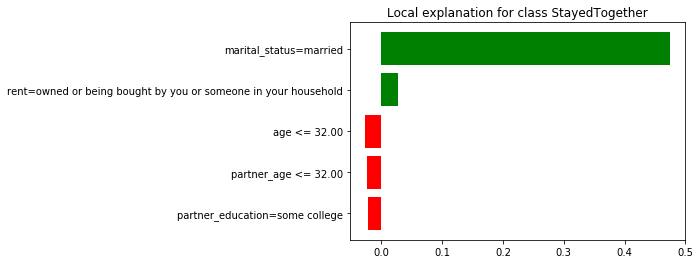

In [12]:
# Explain a prediction ("local interpretability"): 
# Now we see that the pipeline that takes raw data and returns the prediction 
# of the trained model now comes in conveniently.
example = 3
exp = explainer.explain_instance(test[example], pipeline.predict_proba, num_features=5)
print('Couples probability of staying together:', exp.predict_proba[1])
exp.as_pyplot_figure()

Couples probability of staying together: 0.527385574443


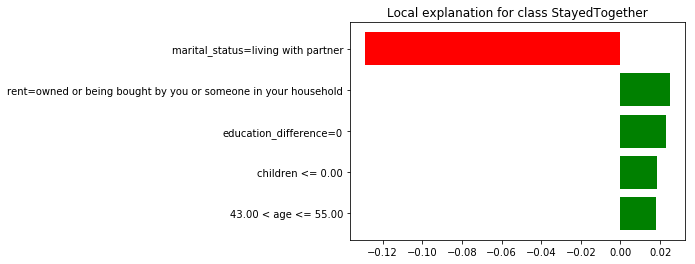

In [13]:
# Explain another prediction ("local interpretability"): 
example = 13
exp = explainer.explain_instance(test[example], pipeline.predict_proba, num_features=5)
print('Couples probability of staying together:', exp.predict_proba[1])
exp.as_pyplot_figure()

In [14]:
# and we see differences in explaining the model's predictions.

Couples probability of staying together: 0.491919162385


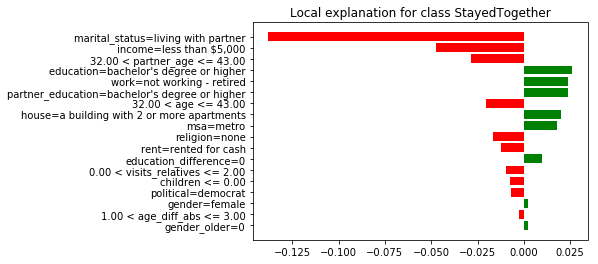

In [19]:
# Using LIME for for relationship management (not advised): Current chance of relationship success.
current = [34, 36, 2, 0, 1, 0, 1, 0, 0, 0, 18, 0, 2, 0, 8, 4, 0, 0]
exp = explainer.explain_instance(np.array(current), pipeline.predict_proba, num_features=20)
print('Couples probability of staying together:', exp.predict_proba[1])
exp.as_pyplot_figure()

Couples probability of staying together: 0.507510079003


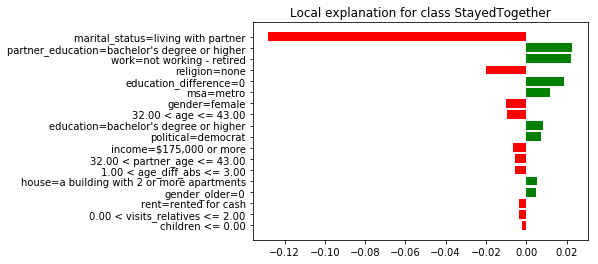

In [20]:
# Should I ask for a pay increase? It doesn't matter much.
increase_income = [34, 36, 2, 0, 1, 0, 1, 0, 0, 0, 6, 0, 2, 0, 8, 4, 0, 0]
exp = explainer.explain_instance(np.array(increase_income), pipeline.predict_proba, num_features=20)
print('Couples probability of staying together:', exp.predict_proba[1])
exp.as_pyplot_figure()

Couples probability of staying together: 0.557617126615


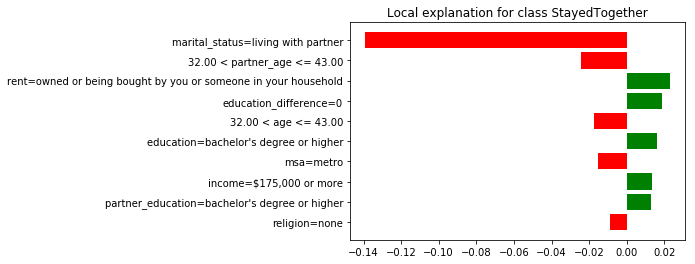

In [21]:
# Should I buy a house? Maybe?
buy_house = [34, 36, 2, 0, 1, 0, 1, 0, 0, 0, 6, 0, 1, 0, 8, 4, 0, 0]
exp = explainer.explain_instance(np.array(buy_house), pipeline.predict_proba, num_features=10)
print('Couples probability of staying together:', exp.predict_proba[1])
exp.as_pyplot_figure()

Couples probability of staying together: 0.815097059517


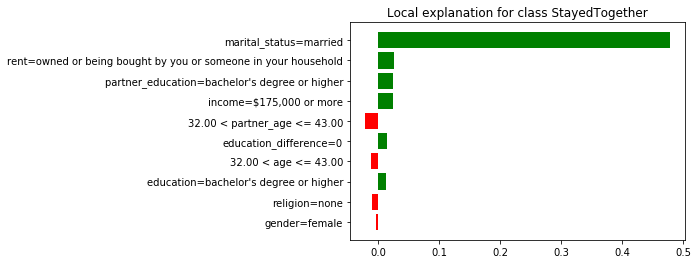

In [22]:
# Really, it's best to get married.
get_married = [34, 36, 2, 0, 1, 0, 2, 0, 0, 0, 6, 0, 1, 0, 8, 4, 0, 0]
exp = explainer.explain_instance(np.array(get_married), pipeline.predict_proba, num_features=10)
print('Couples probability of staying together:', exp.predict_proba[1])
exp.as_pyplot_figure()